## **Data Cleaning**

In [ ]:
# Read the data and store it into a dataframe

import pandas as pd
import math

df = pd.read_excel("Sales_Ops_Case_Study.xlsx","Data")

In [ ]:
# Based on the first sheet of excell file given, replacing the Dispositions into Leads COntacted, Transferred or Not Called for getting better inferences

df["Disposition"] = df["Disposition"].replace(['Abandon','Agent Error','Answering_Machine or VM','Busy','Busy Signal','Caller Disconnected','Dial Error','No Answer','No_Answer','NULL',
                                               'Operator Intercept','Recycle'],'Lead Not Contacted')
df["Disposition"] = df["Disposition"].replace('Warm Transfer','Lead Transferred')
df["Disposition"] = df['Disposition'].replace(['Call Back','Contact Not Available','Courtesy Transfer','Customer Declined','Disconnected',
                                               'Do Not Call','Hang Up','Language Barrier','Lender Not Available','LO Not Available','Not Qualified',
                                               'Requested Callback','Spoke with all available lenders','Warm Transfer','Warm Transfer Failed',
                                               'Working with other lender','Working with other lender or closed','Wrong Number','Contact Not Available ',
                                               'Hold Time Disconnect','Hang Up ','Disconnected ','Working with other lender '],'Lead Contacted')

In [ ]:
# Renaming the column name by removing spaces from them

df.columns=['Call_No','Campaign','Disposition','CallType','Lead_No','Lead_Received','Lead_Called','Loan_Amount','State','Source_of_Lead']

In [ ]:
df["Disposition"].value_counts()

Lead Not Contacted    83516
Lead Contacted        12869
Lead Transferred       7014
Name: Disposition, dtype: int64

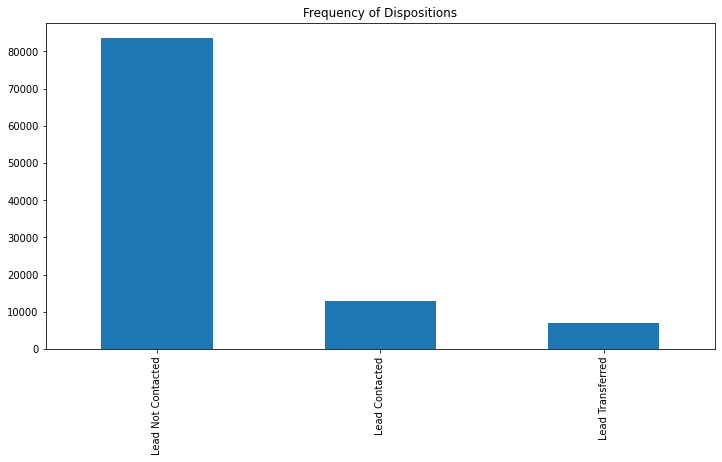

In [ ]:
# Frequency distribution of Leads contacted, not contacted or transferred

df["Disposition"].value_counts().plot(kind='bar', figsize=(12,6), title="Frequency of Dispositions")

**As we can see from the graph, more than 80% of the data has leads that are not contacted. So, removing those rows from the dataframe makes more sense as they won't be useful in calculating the percentages of leads contacted to leads transferred.**

In [ ]:
# Loan amount is a numeric data and hence converting into categories to understand which categories has the highest ratio of leads contacted to transferred
# Categories are:
# Less than 100K, 100k-200k, 200k-300k, 300k-400k, 400k-1,000k, 1,000k-2,000k

import numpy as np

df['Loan_Amount'] = df['Loan_Amount'].mask(df['Loan_Amount'] <= 100000, 0)
df['Loan_Amount'] = np.where(df['Loan_Amount'].between(100000,200000), 1, df['Loan_Amount'])
df['Loan_Amount'] = np.where(df['Loan_Amount'].between(200000,300000), 2, df['Loan_Amount'])
df['Loan_Amount'] = np.where(df['Loan_Amount'].between(300000,400000), 3, df['Loan_Amount'])
df['Loan_Amount'] = np.where(df['Loan_Amount'].between(400000,1000000), 4, df['Loan_Amount'])
df['Loan_Amount'] = np.where(df['Loan_Amount'].between(1000000,2000000), 5, df['Loan_Amount'])
df["Loan_Amount"] = df["Loan_Amount"].astype("category")
df.Loan_Amount.cat.categories = ["<=100k","100k-200k","200k-300k",'300k-400k','400k-1,000k','1,000k-2,000k']

<=100k           25288
100k-200k        32549
200k-300k        18966
300k-400k        10133
400k-1,000k      13648
1,000k-2,000k     2815
Name: Loan_Amount, dtype: int64

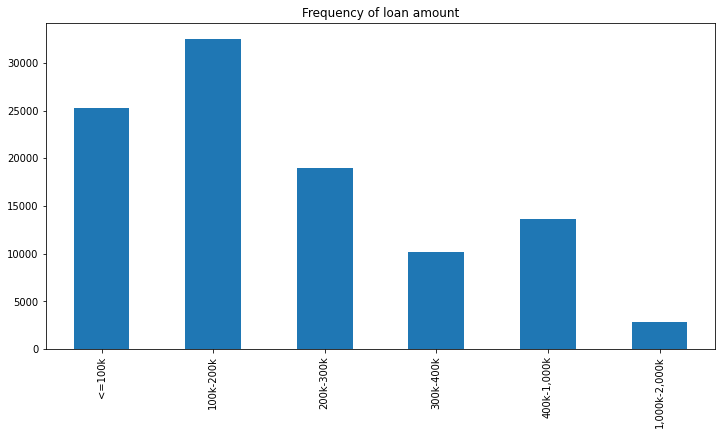

In [ ]:
# Plotting the frequency distribution of each category in Loan Amount

df["Loan_Amount"].value_counts().sort_index().plot(kind='bar', figsize=(12,6), title="Frequency of loan amount")
df["Loan_Amount"].value_counts().sort_index()

**From the graph, highest leads were for the range 100k-200k, followed by less than 100k and then 200k-300k**

In [ ]:
# Dropping the rows where leads are not contacted and for which campaign is Led Inbound since this campaign was about outbound calls
# Storing those values in a new dataframe

new_df = df[df.Disposition != 'Lead Not Contacted']
new_df.reset_index(inplace = True,drop=True) 
new_df = new_df[new_df.Campaign != 'Led Inbound']
new_df.reset_index(inplace = True,drop=True)
new_df['day'] = new_df['Lead_Called'].dt.day_name()
new_df['time'] = new_df['Lead_Called'].dt.hour

In [ ]:
# Getting the list of rows which have multiple calls for the same lead number and store it in a dataframe
# And counting the number of times the each lead was contacted 

dups_lead_no_1 = new_df.pivot_table(index=['Lead_No'], aggfunc='size')
result_1 = dups_lead_no_1[dups_lead_no_1 != 1]
result_1 = pd.DataFrame(result_1)

res_lis_1 = list(result_1.index.values)     # Storing the indexes as a list to create a new column having lead numbers which are repeated
res_lis = []
res_lis = result_1.loc[result_1.index.isin(res_lis_1)]
res_lis["Lead_Num"] = res_lis.index
res_lis.rename(columns = {0:'Count_No_Contacted'}, inplace = True)      # Creating a new column with the count of each lead number contacted

In [ ]:
# Adding that count in the original dataframe by keeping 1 for the leads which were not contacted multiple times

count_contact_times = []
for index,row in new_df.iterrows():
  if row["Lead_No"] in res_lis["Lead_Num"]:
    lead_no = row["Lead_No"]
    count_contact_times.append(res_lis._get_value(lead_no, 'Count_No_Contacted'))
  else:
    count_contact_times.append(1)
new_df["Count_Contact_Times"] = count_contact_times

In [ ]:
new_df["Disposition"].value_counts()

Lead Contacted      11137
Lead Transferred     6405
Name: Disposition, dtype: int64

In [ ]:
# Calculating the time difference in minutes between lead received and lead called to check when is the lead being received and how much time it is taking to contact and then transfer

mins_diff = []
for index,row in new_df.iterrows():
  lead_rec = row["Lead_Received"]
  lead_call = row["Lead_Called"]
  diff = lead_call - lead_rec
  minutes = diff.total_seconds()/60
  if math.isnan(minutes) == False:
    mins_diff.append(round(minutes))
  else:
    mins_diff.append(minutes)
  
new_df["Mins_Diff"] = mins_diff

In [ ]:
# Creating a new column with the label transferred or not transferred

transferred = []
for index,row in new_df.iterrows():
  if (row["Lead_No"] in res_lis["Lead_Num"] and row["Disposition"] == "Lead Transferred") or (row["Disposition"] == "Lead Transferred"):
    transferred.append("Transferred")
  else:
    transferred.append("Not Transferred")
new_df["Transferred"] = transferred

In [ ]:
# For the leads having multiple calls, Calculating the first time lead was called

first_call_time_diff = []
for index,row in res_lis.iterrows():
  mins_list = []
  new_rows = new_df.loc[new_df['Lead_No'] == row["Lead_Num"]]
  first_call_time_diff.append(min(new_rows["Mins_Diff"]))
res_lis["First_Contact_Time_Diff(mins)"] = first_call_time_diff

In [ ]:
# Creating a new column in the original dataframe with the first time contacted values and keeping 0 for the ones that weren't called multiple times

first_cont_time_diff = []
for index,row in new_df.iterrows():
  if row["Lead_No"] in res_lis["Lead_Num"]:
    first_cont_time_diff.append(res_lis._get_value(row["Lead_No"], 'First_Contact_Time_Diff(mins)'))
  else:
    first_cont_time_diff.append(0)
new_df["First_Contact_Time(mins)"] = first_cont_time_diff

In [ ]:
# Removing the multiple rows with the condition that if the lead was transferred in that lead number, then remove other rows
# If the lead wasn't transferred, then remove rows not having maximum time difference

new_df.reset_index(inplace=True,drop=True)
remove_rows = []
for index,row in res_lis.iterrows():
  new_rows = new_df.loc[new_df['Lead_No'] == row["Lead_Num"]]
  indx_list = new_rows.index
  #print(indx_list,row["Lead_Num"])
  if len(new_rows) == 2:
    min_diff = min(new_rows["Mins_Diff"])
    for each in indx_list:
      new_row = new_df.iloc[each]
      if (new_row["Mins_Diff"] == min_diff and new_row["Transferred"] != "Transferred"):
        remove_rows.append(each)
  else:
    max_diff = max(new_rows["Mins_Diff"])
    for each in indx_list:
      new_row = new_df.iloc[each]
      if (new_row["Mins_Diff"] != max_diff and new_row["Transferred"] != "Transferred"):
        remove_rows.append(each)
new_df = new_df.drop(index=remove_rows)
new_df.reset_index(inplace=True,drop=True)

In [ ]:
new_df = new_df.drop(columns = ["Call_No","Disposition","Lead_Received","Lead_Called"])
#new_df

In [ ]:
new_df.to_csv("Cleaned Data.csv",index = False)

In [ ]:
new_df["Day"].value_counts()

Monday       4361
Tuesday      3178
Thursday     2626
Wednesday    2534
Friday       2268
Saturday     1534
Name: Day, dtype: int64

In [ ]:
new_df["Time_Called(Hour)"].value_counts()

8     2311
6     2105
9     1706
11    1528
10    1423
7     1331
12    1189
13    1125
14     998
5      946
15     789
16     701
17     349
Name: Time_Called(Hour), dtype: int64

In [ ]:
new_df["Count_Contact_Times"].value_counts()

1    15581
2      822
3       84
4       11
8        1
6        1
5        1
Name: Count_Contact_Times, dtype: int64

In [ ]:
new_df["Transferred"].value_counts()

Not Transferred    10098
Transferred         6403
Name: Transferred, dtype: int64

In [ ]:
new_df['State'].value_counts()

FL         2366
CA         2302
TX         2272
PA          731
IL          613
MI          582
MA          522
AZ          505
NJ          463
GA          427
VA          417
CO          413
WA          399
TN          389
SC          327
LA          309
MD          299
OK          288
WI          272
OR          250
IN          216
CT          206
KY          204
MN          201
KS          196
NM          153
ID          118
AL          106
NE           95
MT           87
ME           86
NH           84
OH           80
IA           79
WV           77
DE           68
VT           55
RI           54
SD           41
DC           34
WY           31
MS           31
ND           26
NY           12
NC            8
NV            3
Invalid       1
HI            1
AR            1
PR            1
Name: State, dtype: int64

In [ ]:
# Function to plot data against Transferred and plotting bar graph with the count and percentages

import matplotlib.pyplot as plt
import datetime as dt

def plot_bar(col):
  fig, ax = plt.subplots(figsize=(15,7))
  # use unstack()
  height_list = []

  new_df.groupby([f'{col}','Transferred']).size().unstack().plot(ax=ax,kind='bar')

  for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    height_list.append(height)
    if height == 0.0 or height == 0 or height == 1:
      pass
    else:
      ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')
    

  half_len = int(len(height_list)/2)
  perc_list = []
  for i in range(len(height_list)):
    if i < half_len:
      x = height_list[i]
      y = height_list[i+half_len]
      total = x+y
      perc = (x/total)*100
      perc_list.append(perc)
    elif i >= half_len:
      x = height_list[i]
      y = height_list[i-half_len]
      total = x+y
      perc = (x/total)*100
      perc_list.append(perc)

  for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    indx = ax.patches.index(p)
    height_list.append(height)
    if math.isinf(perc_list[indx]) or perc_list[indx] == 0.0:
      pass
    else:
      ax.annotate(f'{perc_list[indx]:.2f}%', (x + width/2, y + height*0.4), ha='center')

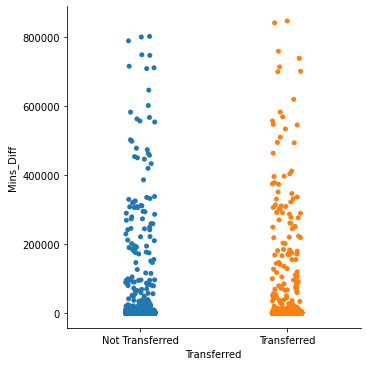

In [ ]:
# Plot scattered graph for transferred against time difference

import seaborn as sns

sns.catplot(x="Transferred", y="Mins_Diff", data=new_df)

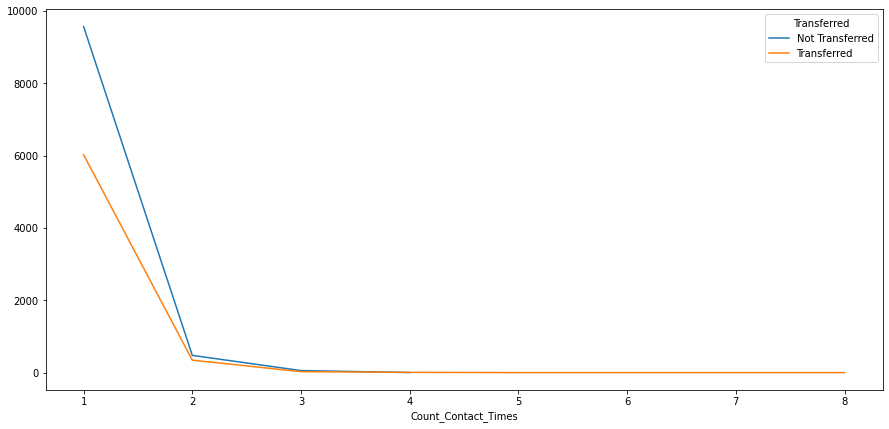

In [ ]:
# Plot count contact times against transferred or not transferred

fig, ax = plt.subplots(figsize=(15,7))
new_df.groupby(['Count_Contact_Times','Transferred']).size().unstack().plot(ax=ax)

**For the leads contacted once, there is a higher ratio of leads contacted to lead transferred. And from 5 onwards, there is no leads contacted, direct transferred.**

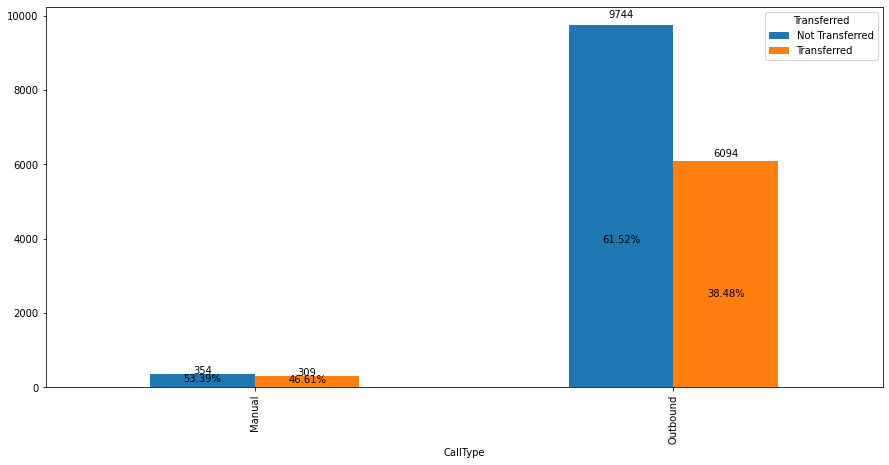

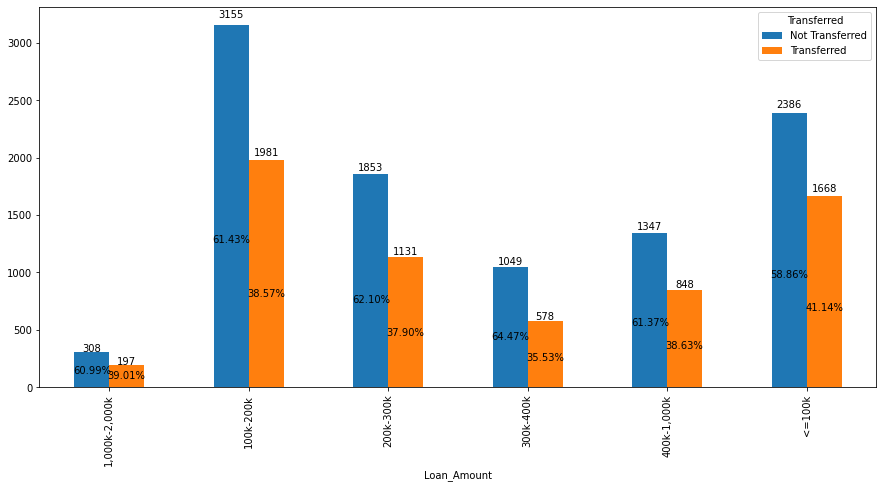

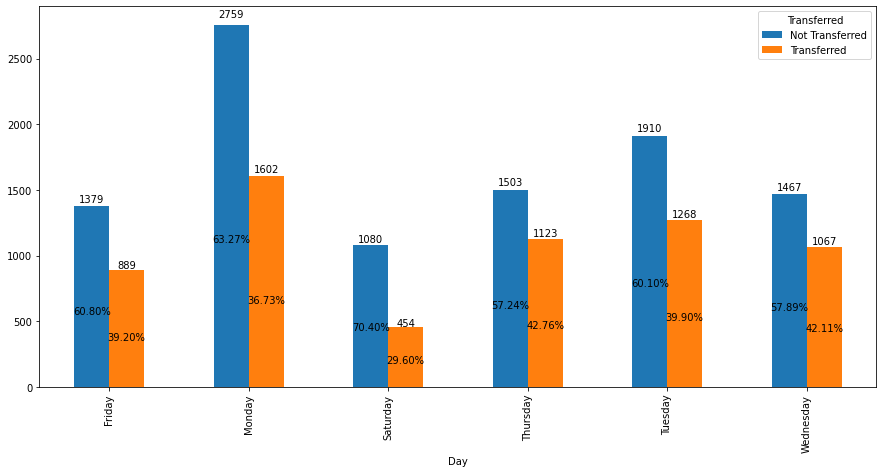

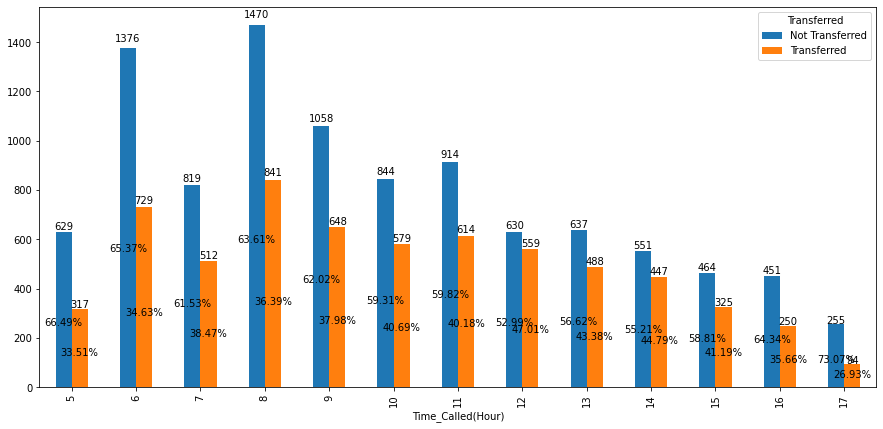

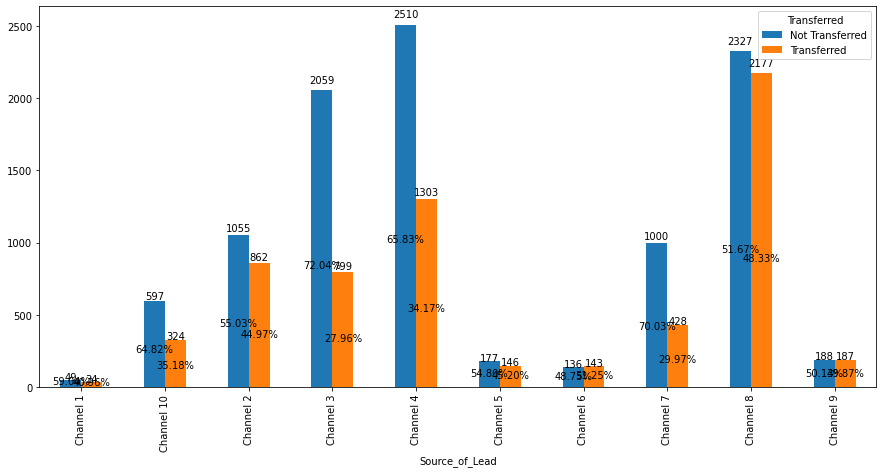

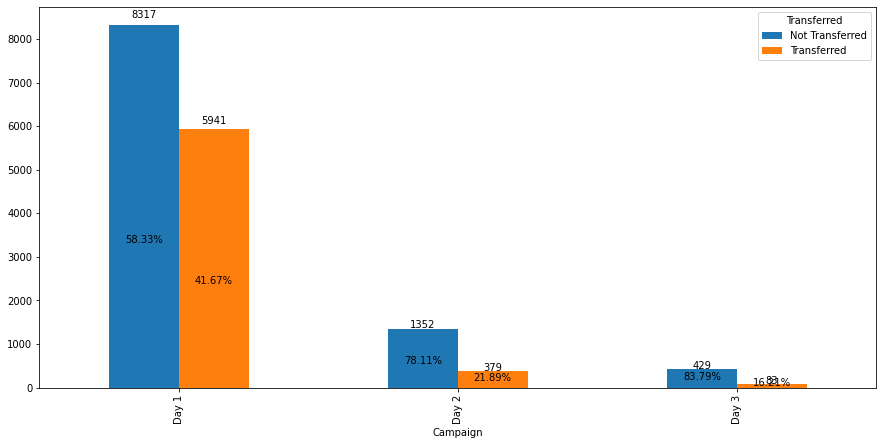

In [ ]:
# Plot all the other graphs

plot_bar('CallType')
plot_bar('Loan_Amount')
plot_bar('Day')
plot_bar('Time_Called(Hour)')
plot_bar('Source_of_Lead')
plot_bar('Campaign')

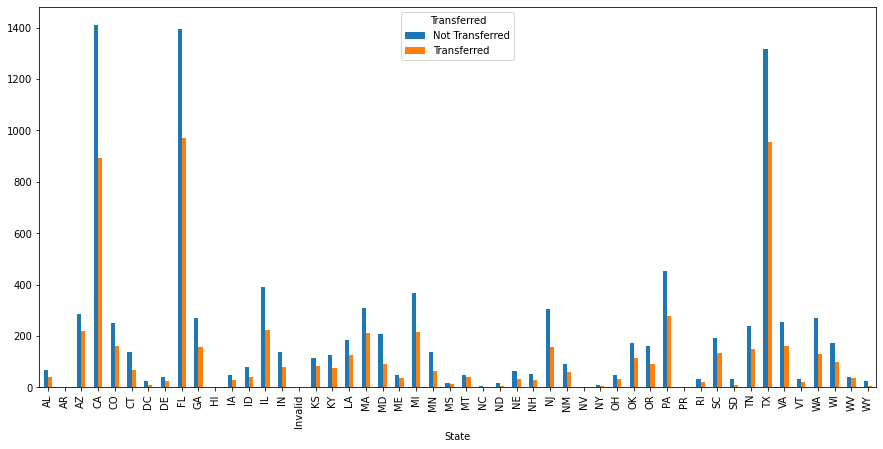

In [ ]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
new_df.groupby(['State','Transferred']).size().unstack().plot(ax=ax,kind='bar')

In [ ]:
# Table for mean, median, min, max , quartile values for Difference in minutes against transferred or not transferred

def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)
new_df.groupby('Transferred').agg({'Mins_Diff':['count','mean','median','std','min','max',q1, q2]})

Mins_Diff                      ...                       
                    count         mean median  ...       max   q1      q2
Transferred                                    ...                       
Not Transferred     10075  4000.421638  175.0  ...  802144.0  0.0  1463.0
Transferred          6389  4965.390515    1.0  ...  846755.0  0.0   655.0

[2 rows x 8 columns]